<a href="https://colab.research.google.com/github/sriRuchitha/OIB-SIP/blob/main/Project_4_Proposal_Level_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this cell first
!pip install -q pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost shap sentence-transformers joblib
# If you just installed packages: Runtime -> Restart runtime, then re-run from top.


In [ ]:
from pathlib import Path
APPS = Path('/mnt/data/apps.csv')
REVIEWS = Path('/mnt/data/user_reviews.csv')
print("apps exists:", APPS.exists())
print("reviews exists:", REVIEWS.exists())

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import joblib
import shap


apps exists: False
reviews exists: False


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving user_reviews.csv to user_reviews (1).csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving apps.csv to apps (1).csv


In [ ]:
import os
print(os.listdir('/content'))


['.config', 'user_reviews (1).csv', 'user_reviews.csv', 'apps (1).csv', 'apps.csv', 'sample_data']


In [ ]:
APPS_PATH = '/content/apps.csv'
REVIEWS_PATH = '/content/user_reviews.csv'


In [ ]:
APPS = Path('/mnt/data/apps.csv')
REVIEWS = Path('/mnt/data/user_reviews.csv')


In [ ]:
from pathlib import Path
APPS = Path('/content/apps.csv')
REVIEWS = Path('/content/user_reviews.csv')


In [ ]:
def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, low_memory=False)

apps = safe_read_csv(APPS)
reviews = safe_read_csv(REVIEWS)

print("apps:", apps.shape)
print("reviews:", reviews.shape)
apps.head()


apps: (9659, 14)
reviews: (64295, 5)


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
def diag(df, name):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("dtypes counts:\n", df.dtypes.value_counts())
    print("top null counts:\n", df.isna().sum().sort_values(ascending=False).head(10))
diag(apps, "APPS")
diag(reviews, "REVIEWS")



=== APPS ===
shape: (9659, 14)
dtypes counts:
 object     10
int64       2
float64     2
Name: count, dtype: int64
top null counts:
 Rating         1463
Size           1227
Current Ver       8
Android Ver       2
App               0
Unnamed: 0        0
Reviews           0
Category          0
Installs          0
Type              0
dtype: int64

=== REVIEWS ===
shape: (64295, 5)
dtypes counts:
 object     3
float64    2
Name: count, dtype: int64
top null counts:
 Translated_Review         26868
Sentiment_Polarity        26863
Sentiment                 26863
Sentiment_Subjectivity    26863
App                           0
dtype: int64


In [ ]:
# normalize column names
apps.columns = apps.columns.str.strip()

# Example: convert Installs, Price, Reviews to numeric if these columns exist
if 'Installs' in apps.columns:
    apps['Installs_clean'] = apps['Installs'].astype(str).str.replace('[+,]', '', regex=True).str.replace('Free','0')
    apps['Installs_clean'] = pd.to_numeric(apps['Installs_clean'], errors='coerce').fillna(0).astype(int)

if 'Price' in apps.columns:
    apps['Price_clean'] = apps['Price'].astype(str).str.replace('[$,]', '', regex=True).replace('','0')
    apps['Price_clean'] = pd.to_numeric(apps['Price_clean'], errors='coerce').fillna(0.0)

# Ensure Rating column exists for supervised demo; rename if necessary
if 'rating' in apps.columns and 'Rating' not in apps.columns:
    apps.rename(columns={'rating':'Rating'}, inplace=True)


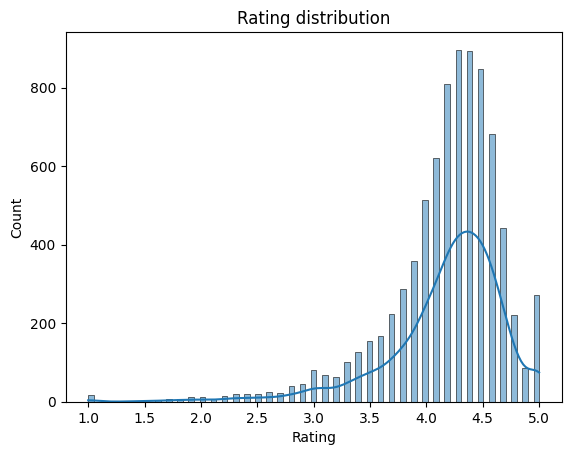

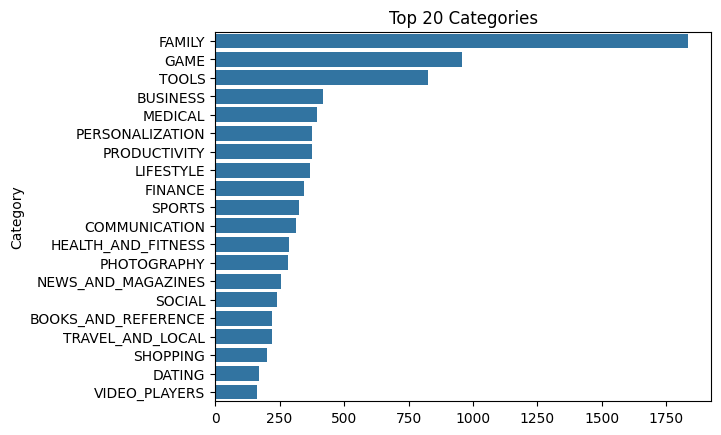

In [ ]:
# distribution of ratings
if 'Rating' in apps.columns:
    sns.histplot(apps['Rating'].dropna(), kde=True)
    plt.title('Rating distribution'); plt.show()

# top categories
if 'Category' in apps.columns:
    top = apps['Category'].value_counts().nlargest(20)
    sns.barplot(y=top.index, x=top.values)
    plt.title('Top 20 Categories'); plt.show()


In [ ]:
# create target: high-rated (Rating >= 4.0)
if 'Rating' not in apps.columns:
    raise RuntimeError("No 'Rating' column found — adapt the script for your target task.")

apps2 = apps.dropna(subset=['Rating']).copy()
# choose numeric features that exist
cands = [c for c in ['Installs_clean','Price_clean','Reviews'] if c in apps2.columns]
if not cands:
    apps2['dummy'] = 1.0
    cands = ['dummy']

X = apps2[cands].copy()
# coerce to numeric defensively
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0.0)
y = (apps2['Rating'] >= 4.0).astype(int)
print("Features used:", cands, "X shape:", X.shape, "y dist:", y.value_counts().to_dict())


Features used: ['Installs_clean', 'Price_clean', 'Reviews'] X shape: (8196, 3) y dist: {1: 6286, 0: 1910}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
from collections import Counter
print("train class counts:", Counter(y_train))
# apply SMOTE only if minority class has >=2 samples
if min(Counter(y_train).values()) < 2:
    print("Too few minority examples — skipping SMOTE")
    X_train_res, y_train_res = X_train, y_train
else:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("after SMOTE:", Counter(y_train_res))
# scale
scaler = StandardScaler().fit(X_train_res)
X_train_res_s = scaler.transform(X_train_res)
X_test_s = scaler.transform(X_test)


train class counts: Counter({1: 5028, 0: 1528})
after SMOTE: Counter({1: 5028, 0: 5028})


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res_s, y_train_res)
print("Test accuracy:", rf.score(X_test_s, y_test))
# quick classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test_s)))


Test accuracy: 0.6207317073170732
              precision    recall  f1-score   support

           0       0.30      0.49      0.38       382
           1       0.81      0.66      0.73      1258

    accuracy                           0.62      1640
   macro avg       0.56      0.58      0.55      1640
weighted avg       0.69      0.62      0.65      1640



shap shape: (500, 3, 2) sample shape: (500, 3)


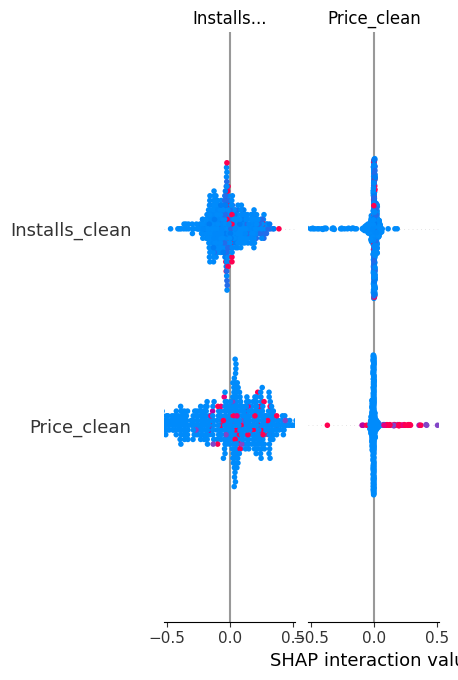

In [ ]:
# Use the SAME sample for shap_values and plotting
sample_df = pd.DataFrame(X_test_s, columns=X_test.columns)
n = min(500, sample_df.shape[0])
sample = sample_df.sample(n, random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(sample)   # for classifier -> list for classes
# pick class index 1 for positive class if available
if isinstance(shap_values, list):
    idx = 1 if len(shap_values) > 1 else 0
    plot_vals = shap_values[idx]
else:
    plot_vals = shap_values

print("shap shape:", np.array(plot_vals).shape, "sample shape:", sample.shape)
shap.summary_plot(plot_vals, sample)  # will render inline in Colab


In [ ]:
!pip install -q nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).lower()
    s = s.replace('\n',' ')
    return s

reviews['clean_review'] = reviews.get('review', reviews.columns[0]).apply(clean_text) if 'review' in reviews.columns else reviews.iloc[:,0].astype(str).apply(clean_text)
reviews['sentiment_score'] = reviews['clean_review'].apply(lambda t: sia.polarity_scores(t)['compound'])
# aggregate per app (if matching key column exists)
if 'App' in reviews.columns and 'App' in apps2.columns:
    agg = reviews.groupby('App')['sentiment_score'].agg(['mean','count']).rename(columns={'mean':'avg_sentiment','count':'n_reviews'})
    apps2 = apps2.merge(agg, left_on='App', right_index=True, how='left').fillna({'avg_sentiment':0,'n_reviews':0})
    print("Merged review aggregates into apps")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Merged review aggregates into apps
